# I2K Workshop 2024

This hands-on workshop will introduce you to CytoDL, a powerful deep learning framework developed by the Allen Institute for Cell Science. CytoDL is designed to streamline the analysis of biological images, including 2D and 3D data represented as images, point clouds, and tabular formats.
You will learn how to leverage CytoDL to:

A. Get single cell and nucleus instance segmentations from image datasets from the Allen Institute from Cell Science [1, 2]

B. Use the single cell images from (A) to extract unsupervised features to detect morphological perturbations of intracellular structures [2].

[1] - Viana, Matheus P., et al. "Integrated intracellular organization and its variations in human iPS cells." Nature 613.7943 (2023): 345-354.

[2] - Donovan-Maiye, Rory M., et al. "A deep generative model of 3D single-cell organization." PLOS Computational Biology 18.1 (2022): e1009155.


## What is CytoDL?

CytoDL is a python-based package that aims to make deep-learning based microscopy image analysis projects modular, maintainable, and reproducible​ by
​
1. Identifying common structural components​ of these projects​,
2. Providing new components and making incorporation of open-source components easy, and  ​
3. Providing recipes for combining custom and open source components​
​

Using the configurability of [hydra](https://hydra.cc/), CytoDL allows users to easily switch between different models, datasets, and training configurations. CytoDL also provides a set of project templates to quickly train 2D and 3D models for in-silico labeling, semantic and instance segmentation, classification, contrastive learning, and masked image modeling. To better understand the capabilities of CytoDL, let's first examine the configuration file for a single experiment training an instance segmentation model. 

CytoDL models are most commonly used from the CLI, for the sake of this notebook we will use the API (in beta) to showcase its programmatic use. 

First, we will load a model from its configuration file.

In [ ]:
from cyto_dl.api import CytoDLModel

model = CytoDLModel()
model.load_config_from_file(WORKING_DIR/'configs/instance_seg_train.yaml')

Models can be loaded by their configuration files, from a dictionary, or from one of the provided templates. When loading the configuration, overrides can be provided to change the configuration parameters.

### Data Config
First, let's examine the data configuration. Here, we specify a training and validation dataloader that takes in numpy arrays and performs a sequence of transforms on them to normalize the raw input data and transform the segmentation images into an appropriate format for model training. Notice that each python object (the dataloader and transforms) that will ultimately be used in training is specified in the config using the hydra `_target_` syntax to specify the function and its arguments to be instantiated. This results in flexibility and reproducibility - configurations uniquely specify the data pipeline used and allows easy interchangeability of transforms (e.g. from CytoDL, monai, pytorch, etc.). The OmegaConf interpolation syntax (`${variable}`) is also used to create consistency within and between configuration files. CytoDL also provides utilities for common microscopy data formats and datamodules for loading datasets specified by file paths or folders instead of raw numpy arrays

In [ ]:
from cyto_dl.utils.rich_utils import print_config_tree
print_config_tree(model.cfg.data, print_order=[])

### Model Config


In the model config, we specify how data flows through our project to create a trained model. Here, we use the `MultiTaskIm2Im` class, which creates models with a shared backbone and then (optionally multiple) task-specific heads that take shared backbone features as input. In this case, we have a single task head for instance segmentation, which performs additional convolution on the backbone features to create a 6-channel output (we'll dig into what this looks like in a minute) and is optimized with a custom loss function. 
Optimization parameters like learning rate schedulers are also provided in the model config.

In [ ]:
print_config_tree(model.cfg.model, print_order=[])

### Trainer Config
We use PyTorch Lightning for training, which allows us to specify the training loop in a modular way. The trainer config specifies the number of epochs, the number of GPUs to use, and other training parameters.

In [ ]:
print_config_tree(model.cfg.trainer, print_order=[])

### Experiment Config
The experiment config composes each of the above configurations (as well as configurations for callbacks, loggers, saving paths, and other parameters) to create a full training pipeline. This is the configuration file that is passed to the `train` function to start training. This modularity (plus the ability to override parameters from the command line or the experiment config) makes it easy to experiment with different models, data, and training parameters.

With a basic understanding of CytoDL established, let's dive into our single cell dataset and then train a model!

## Single Cell Dataset Creation


### Training a Cell Instance Segmentation Model
We will use the dataset from [1] to train a cell instance segmentation model using CytoDL for application on our drug perturbation dataset. 


1. Downloading the dataset

In [ ]:
from pathlib import Path
WORKING_DIR = Path.cwd()

In [ ]:
import quilt3
import tqdm

def download_dataset(save_path, n_subsample=1):
    # set up save directories
    raw_path = Path(save_path)
    (raw_path/'raw').mkdir(parents=True, exist_ok=True)
    (raw_path/'seg').mkdir(parents=True, exist_ok=True)

    # connect to quilt
    pkg = quilt3.Package.browse("aics/hipsc_single_cell_image_dataset", registry="s3://allencell")
    meta_df = pkg["metadata.csv"]().sample(n=n_subsample)
    for row in tqdm.tqdm(meta_df.itertuples(), desc="Downloading images"):
        # get raw images
        subdir_name = row.fov_path.split("/")[0]
        file_name = row.fov_path.split("/")[1]
        local_fn = raw_path / 'raw' / f"{row.FOVId}.tiff"
        pkg[subdir_name][file_name].fetch(local_fn)

        # get segmentation masks
        subdir_name = row.fov_seg_path.split("/")[0]
        file_name = row.fov_seg_path.split("/")[1]
        local_fn = raw_path / 'seg' / f"{row.FOVId}.tiff"
        pkg[subdir_name][file_name].fetch(local_fn)


In [ ]:
download_dataset(WORKING_DIR/'local_data', n_subsample=10)

2. Visualizing Instance Segmentation

Inspired by methods like CellPose, Omnipose, and SKOOTS, CytoDL implements a vector-field based approach to instance segmentation. This approach is particularly useful for segmenting cells that are touching or overlapping. This type of model predicts 6 channels:

[1] A connectivity-preserving erosion that forms the "core" of each object

[2] A semantic segmentation generated by thresholding the instance segmentation

[3-6] ZYX vector fields that predict the direction to the nearest object boundary from channel 1 in each direction 

During postprocessing, we use the Ch.2 to identify foreground pixels and then split objects using the vector fields and a connected component labeling of Ch. 1. 

In [ ]:
from bioio import BioImage
from cyto_dl.models.im2im.utils.instance_seg import InstanceSegPreprocessd
import numpy as np
import torch

def load(fn, C):
    return BioImage(fn).get_image_dask_data('ZYX', C=C).compute()

def load_cell_seg(fn):
    return load(fn, 1)

def load_structure(fn):
    img = BioImage(fn)
    ch_names = img.channel_names
    try:
        ch = ch_names.index('EGFP_2')
    except:
        ch = ch_names.index('EGFP')
    return load(fn, ch)

def load_membrane(fn):
    img = BioImage(fn)
    ch_names = img.channel_names
    try:
        ch = ch_names.index('CMDRP_2')
    except:
        ch = ch_names.index('CMDRP')
    return load(fn, ch)

def generate_gt(seg):
    preprocess = InstanceSegPreprocessd(label_keys='seg')
    seg = preprocess({'seg':torch.from_numpy(seg)})
    return seg['seg']

def select_full_cell(seg):
    cells = set(np.unique(seg))
    cells.remove(0)
    border_mask = np.ones_like(seg).astype(bool)
    border_mask[1:-1,1:-1, 1:-1] = False
    border_cellids = set(np.unique(seg[border_mask]))
    full_cells = list(cells - border_cellids)
    return np.random.choice(full_cells, size=1)[0]


def visualize_example():
    # select random example
    files = list((WORKING_DIR / 'local_data/raw').iterdir())
    example_fn = np.random.choice(files)
    # load images
    raw = load_membrane(example_fn)
    seg = load_cell_seg(str(example_fn).replace('raw','seg'))
    print('Example images loaded')
    # visualize a random cell
    cell_id = select_full_cell(seg)
    # generate ground truth for model training
    multich_gt = generate_gt(seg==cell_id)
    print("Instance segmentation ground truth generated")

    return np.concatenate([raw[None],multich_gt], axis=0)

# example = visualize_example()


3. Model training

Now that we have a few examples of the dataset downloaded and we understand the format of the instance segmentation ground truth, we can start model training. To keep things quick, we'll just train for 1 epoch. In practice, you would want to train for many more epochs. Notice how we can provide overrides to the training function to allow programmatic manipulation of the configuration.

In [ ]:
# train instance seg model
from cyto_dl.api import CytoDLModel
from sklearn.model_selection import train_test_split
import tqdm

def load_dataset():
    """
    Load small dataset for quick training
    """
    raw = []
    seg = []
    for raw_fn, seg_fn in tqdm.tqdm(zip((WORKING_DIR / 'local_data/raw').iterdir(), (WORKING_DIR / 'local_data/seg').iterdir()), desc='Loading dataset'):
        # load and add channel dimension
        raw.append(load_membrane(raw_fn)[None])
        seg.append(load_cell_seg(seg_fn)[None])

        if len(raw) == 3:
            break

    raw_train, raw_val, seg_train,  seg_val = train_test_split(raw, seg, test_size=1)
    train_data = [{'raw': rt, 'seg': st} for rt, st in zip(raw_train, seg_train)]
    val_data = [{'raw': rv, 'seg': sv} for rv, sv in zip(raw_val, seg_val)]
    return {
        'train': train_data,
        'val': val_data
    }

def train_model(cfg_path:str,  dataset, overrides={}):
    # load model
    model = CytoDLModel()
    model.load_config_from_file(cfg_path)

    # apply overrides
    model.override_config(overrides)

    output_path = WORKING_DIR/'local_data'/'instance_seg_train'
    model.cfg.paths.output_dir = output_path
    Path(output_path).mkdir(parents=True, exist_ok=True)

    # apply model
    model.train(data=dataset)

# train_dataset, val_dataset 
# data = load_dataset()
    
train_model(WORKING_DIR/'configs/instance_seg_train.yaml', dataset=data, overrides={'trainer.max_epochs':1})

### Dataset Creation

Now that we have the trained model (here we'll use a pretrained one instead of the one we just trained for a single epoch), we will use it to create a dataset of single cell images from the drug perturbed and non-perturbed datasets.

First, we will generate FOV-level instance segmentations. 

In [ ]:
from cyto_dl.utils import extract_array_predictions
import matplotlib.pyplot as plt

# apply instance seg model
def apply_model(cfg_path:str,  dataset, overrides={}):
    # load model
    model = CytoDLModel()
    model.load_config_from_file(cfg_path)

    # apply overrides
    model.override_config(overrides)

    output_path = model.cfg.paths.output_dir
    Path(output_path).mkdir(parents=True, exist_ok=True)

    # apply model
    _, _, output = model.predict(data=data)
    preds = extract_array_predictions(output)
    return preds

# raw_fn = (WORKING_DIR / 'local_data/raw').iterdir().__next__()
# data = [load_membrane(raw_fn)[None]]
# print('Example images loaded')

pred = apply_model(WORKING_DIR/'configs'/'instance_seg_predict.yaml', data, overrides={'paths.output_dir': str(WORKING_DIR/'local_data/instance_seg_apply')})


fig, ax= plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(data[0][30])
ax[2].imshow(pred[0][30])

We can then use these segmentations to extract single cell images from the FOVs and normalize them. We exclude cells that are too small (likely noise from our segmentation model) or cells that touch the edge of the FOV, rotate them in the YX plane to align the major axis of the cell with the X axis, and crop them to a fixed size.

In [ ]:
import numpy as np
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops_table
import pandas as pd
import tqdm
from monai.transforms import SpatialCrop
from scipy.ndimage import binary_dilation
from aicsshparam import shtools


def remove_border(img):
    # remove instances touching the border
    mask = np.ones_like(img, dtype=bool)
    mask[1:-1, 1:-1, 1:-1] = False
    border_idxs = np.unique(img[mask])
    img[np.isin(img, border_idxs)] = 0
    return img

def normalize(img):
    # remove background
    img = img-np.median(img)
    # clip image values to 50-99.98 percentile
    max = np.percentile(img, 99.98)
    img[img>max] = max
    img[img<0] = 0
    # rescale to 0-255
    img = rescale_intensity(img, out_range=(0, 255))
    return img

def extract_single_cells(raw_fn, seg_fn, size_threshold=2e5, crop_size=[56, 256, 384]):
    raw = load_structure(raw_fn)
    raw = normalize(raw)

    seg = load_cell_seg(seg_fn)
    seg = remove_border(seg)
    
    props = pd.DataFrame(regionprops_table(seg, properties=('label', 'slice','area')))
    # remove small objects
    props = props[props['area'] > size_threshold]

    cells = []
    for i, row in tqdm.tqdm(props.iterrows()):
        crop = raw[row['slice']]

        seg_crop = seg[row['slice']] == row['label']
        seg_crop = binary_dilation(seg_crop, iterations=1)

        # find rotation to make longest axis vertical
        seg_crop, angle = shtools.align_image_2d(seg_crop)
        crop = shtools.rotate_image_2d(crop[None], angle, interpolation_order = 3)

        # center crop on seg_crop centroid
        z, y, x = np.where(seg_crop.squeeze())
        centroid = np.array([np.mean(z), np.mean(y), np.mean(x)])
        cropper= SpatialCrop(centroid, crop_size)

        # set background to -1
        crop[seg_crop ==0] = -1

        # ensure crop is smaller than crop_size
        crop = cropper(crop).squeeze()
        # pad evenly to crop_size
        padding= np.array(crop_size) - np.array(crop.shape)
        padding_left = padding//2
        padding_right = padding - padding_left
        crop = np.pad(crop, ((padding_left[0], padding_right[0]), (padding_left[1], padding_right[1]), (padding_left[2], padding_right[2])), mode='constant', constant_values=-1)
    return np.stack(cells)

raw_fn = list((WORKING_DIR/'local_data/raw/').glob('*'))[0]
seg_fn = list((WORKING_DIR/'local_data/seg/').glob('*'))[0]

single_cells = extract_single_cells(raw_fn, seg_fn)

## Feature Extraction and Applications for Perturbation Detection

### VICReg Training


[VICReg](https://arxiv.org/pdf/2105.04906) is a contrastive learning method that incoroporates three principles for learning meaningful representations:
1. Variance - within a batch, features should be diverse. This prevents representational collapse
2. Invariance - features should be invariant to transformations of the input
3. Covariance - latent features should be independent (i.e. identity covariance)

This method combines three loss functions to enforce these principles. 

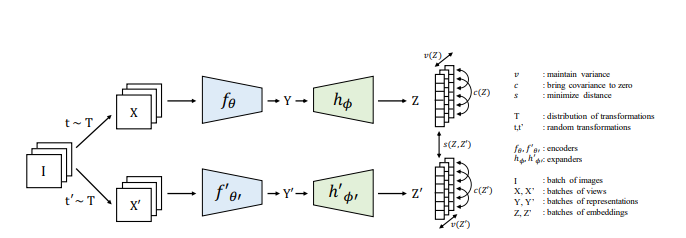

**Image from the VICReg paper**

The choice of augmentations to make learned features invariant to is highly domain-dependent and requires some experimentation. Here, we apply random flips, rotations, intensity shifts, Gaussian smoothing, and resizing on two copies of the same cell. We train on  *just* the non-drug treated dataset, and will then apply the trained model on a separate dataset containing drug- and vehicle-treated cells.


In [ ]:
# show cytodl training

### Feature Analysis


To get a rough sense of the impact of various drug treatments on our structures of interest, we can start our analysis by visualizing the learned features in a 2D space using PCA. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_features():
    return pd.read_csv(WORKING_DIR/'assets/features/predictions.csv')

def get_feature_columns():
    return [str(i) for i in range(256)]

def visualize_treatments(pcs, df):
    genes = df.Gene.unique()
    drugs = [d for d in df.drug_label.unique() if d != 'Vehicle']
    
    n_rows, n_cols = len(genes), len(drugs)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), squeeze=False)
    
    # Set a cohesive style
    plt.style.use('seaborn-v0_8')
    colors = plt.cm.Set2(np.linspace(0, 1, 8))
    
    for i, gene in enumerate(genes):
        for j, drug in enumerate(drugs):
            ax = axes[i, j]
            
            # Set titles and labels
            if i == 0:
                ax.set_title(drug, fontsize=14, fontweight='bold')
            if j == 0:
                ax.set_ylabel(gene, fontsize=14, fontweight='bold')
            
            drug_idx = (df.Gene == gene) & (df.drug_label == drug)
            veh_idx = (df.Gene == gene) & (df.drug_label == 'Vehicle')
            
            if drug_idx.sum() > 0:
                ax.scatter(pcs[veh_idx, 0], pcs[veh_idx, 1], c=[colors[0]], label='Vehicle', alpha=0.7, edgecolors='none')
                ax.scatter(pcs[drug_idx, 0], pcs[drug_idx, 1], c=[colors[1]], label=drug, alpha=0.7, edgecolors='none')
                ax.set_xlim(-20, 20)
                ax.set_ylim(-20, 20)
                ax.legend(fontsize=10)
                ax.set_xlabel('PC1', fontsize=12)
                if j > 0:
                    ax.set_ylabel('PC2', fontsize=12)
                
                # Remove top and right spines
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
    
    plt.tight_layout()
    return fig

# Load and process data
features = load_features()
feat_cols = get_feature_columns()

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

pcs = pipeline.fit_transform(features[feat_cols])
print('Explained variance ratio:', pipeline.named_steps['pca'].explained_variance_ratio_)

# Create and display the visualization
fig = visualize_treatments(pcs, features)
plt.show()

While the drug and vehicle distributions are highly overlapping for most cell line / drug combinations, a few interactions stand out as having a clear effect on the distribution of features: Tubulin and Paclitaxol, Golgi and Brefeldin, and Golgi and s-Nitro-Blebbistatin. To better understand the morphological changes that these drugs induce, we can find the axis that best separates the two distributions in PC space and visualize the cells along this axis.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from bioio.bio_image import imread
from tqdm import tqdm

def visualize_LDA(df, pcs, gene, drug, scale_low=20, scale_high=10):
    # Set style
    plt.style.use('seaborn-v0_8')
    colors = plt.cm.Set2(np.linspace(0, 1, 8))

    # Find indices in dataframe for gene and drug/vehicle
    veh_idx = (df.Gene == gene) & (df.drug_label == 'Vehicle')
    drug_idx = (df.Gene == gene) & (df.drug_label == drug)

    # Apply indices to pcs
    veh_pcs = pcs[veh_idx]
    drug_pcs = pcs[drug_idx]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # PCA Projection plot
    ax1.scatter(veh_pcs[:, 0], veh_pcs[:, 1], c=[colors[0]], label='Vehicle', alpha=0.7, edgecolors='none')
    ax1.scatter(drug_pcs[:, 0], drug_pcs[:, 1], c=[colors[1]], label=drug, alpha=0.7, edgecolors='none')

    # Fit LDA
    X = np.concatenate([veh_pcs, drug_pcs])
    y = np.concatenate([np.zeros(veh_pcs.shape[0]), np.ones(drug_pcs.shape[0])])

    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit_transform(X, y)
    lda_direction = lda.coef_[0]
    lda_line = np.array([-lda_direction*scale_low, lda_direction*scale_high])

    arrow_start = lda_line[0]
    arrow_end = lda_line[1]
    arrow_vector = arrow_end - arrow_start

    ax1.arrow(arrow_start[0], arrow_start[1], 
          arrow_vector[0], arrow_vector[1],
          color='r', width=0.2, head_width=1.0, head_length=1.0, 
          length_includes_head=True, label='LDA direction')
    ax1.set_xlabel('PC1', fontsize=12)
    ax1.set_ylabel('PC2', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.set_title('PCA Projection', fontsize=14, fontweight='bold')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_aspect('equal')

    # LDA Projection plot
    ax2.hist(X_lda[y == 0], bins=50, color=colors[0], density=True, label='Vehicle', alpha=0.5)
    ax2.hist(X_lda[y == 1], bins=50, color=colors[1], density=True, label=drug, alpha=0.5)
    ax2.set_xlabel('LDA Coordinates', fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.set_title('LDA Projection', fontsize=14, fontweight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
    return lda_line

def visualize_latent_walk(walk, df, feats, drug, gene, path_column='path'):
    # Extract drug and gene rows
    idx = (df.Gene == gene) & (df.drug_label.isin([drug, 'Vehicle']))
    df = df[idx]
    feats = feats[idx]
    
    movie = []
    # Find 4 closest examples at each point along walk
    for w in tqdm(walk, desc='Traversing PC-LDA line'):
        dist = np.linalg.norm(feats - w, axis=1)
        dist_argsort = np.argsort(dist)
        examples = []
        for idx in dist_argsort[:4]:
            img = imread(df.iloc[idx][path_column]).squeeze().max(0)
            examples.append(img)
        examples = np.vstack(examples)
        movie.append(examples)
    movie = np.hstack(movie)

    # Plot movie
    plt.figure(figsize=(20, 5))
    plt.imshow(movie, cmap='gray')
    plt.axis('off')
    
    # Set xticks with coordinates in w
    plt.xticks(np.linspace(0, movie.shape[1], len(walk)), 
               labels=np.round(walk, 2), 
               rotation=45, ha='right')
    
    plt.xlabel('LDA coordinates', fontsize=12)
    plt.ylabel("Nearest Neighbors", fontsize=12)
    plt.title(f'{gene} x {drug} latent walk', fontsize=14, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(label='Pixel Intensity')
    
    plt.tight_layout()
    plt.show()

## Tubulin and Paclitaxol.

In [ ]:
drug = 'Paclitaxol'
gene = 'TUBA1B'

lda_line = visualize_LDA(features,pcs, gene, drug, scale_low=30, scale_high=40)
visualize_latent_walk(np.linspace(lda_line[0], lda_line[1], 10), features, pcs, drug, gene)

Traversing the LDA line shows a marked decrease in intensity as we move from Paclitaxol-treated cells to Vehicle-treated cells. In addition, the distribution of tubulin seems to change - the Paclitaxol-treated cells have very bright bundles of tubulin, while vehicle-treated cells have more diffuse, uniform tubulin.

## Golgi and Brefeldin

In [ ]:
drug = 'Brefeldin'
gene = 'ST6GAL1'

lda_line = visualize_LDA(features, pcs, gene, drug, scale_low=15, scale_high=20)
visualize_latent_walk(np.linspace(lda_line[0], lda_line[1], 10), features, pcs, drug, gene)

With Brefeldin-treated cells, we again see a significant change in Golgi distribution, with Brefeldin-treated cells having a distinct,diffuse Golgi distribution. Brefeldin is known to cause disassembly of the Golgi apparatus, and this is reflected in the features of our model as the primary difference between the drug- and vehicle-treated cells.

## Golgi and s-Nitro-Blebbistatin

In [ ]:
drug = 's-Nitro-Blebbistatin'
gene = 'ST6GAL1'

lda_line = visualize_LDA(features, pcs, gene, drug, scale_low=15, scale_high=20)
visualize_latent_walk(np.linspace(lda_line[0], lda_line[1], 10), features, pcs, drug, gene)

s-Nitro-Blebbistatin treatment causes a similar dissolution of the Golgi apparatus, from clusters of puncta to a diffuse and blobby morphology. 